# Overview: Modify Parameterized Ejecta Models to Analyze Synthetic Spectral Differences

Whether you are using TARDIS to post-process hydro model outcomes or finding a parameterized model to match observations, understanding how ejecta model parameters affect synthetic spectra is crucial for analyzing the physical outcomes of your work. 

Let's make some variations of the input ejecta model and explore the spectral differences! 

To make this process more engaging, we provide the following files for this notebook:
- `tardis_uniform_abundance.yml`: The TARDIS configuration file based on the work from [O'Brien 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...916L..14O/abstract) for inferring the observed spectrum of SN2002bo at early times (parameters are modified for the purpose of this notebook).
- An observed spectrum file of SN2002bo at early times from [Silverman et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1789S/abstract): Intended to be used as a reference spectrum when adjusting the ejecta model parameters. 

---

$\blacktriangleright$ Run the cell below to import the modules you need. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d

from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
from tardis.visualization import SDECPlotter, LineInfoWidget, CustomAbundanceWidget
from tardis.visualization.tools.liv_plot import LIVPlotter
from tardis.util.base import atomic_number2element_symbol, int_to_roman, element_symbol2atomic_number
from tardis.workflows.util import get_tau_integ


from astropy import units as u
from astropy import constants as const


# Load the observed spectrum

The original observed spectrum is taken from [WISEReP](https://www.wiserep.org/object/7161), contributed by [Silverman et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1789S/abstract). 

Based on [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract), SN2002bo has the following properties:
- Redshift = 0.0043
- Distance (d) = 31.67 Mpc
- UVOIR luminosity at this epoch ~ 2e42 erg/s, with roughly 80% contributing to the observed wavelength range of the given spectrum.
- Rest frame epoch of -12 days relative to peak light.

The file is available at `configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat`.

---

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Assuming the observed spectrum is flux-calibrated, convert the observed flux to luminosity density so that we can compare with the TARDIS synthetic spectra directly. Use astropy units for this task. Integrate over the converted luminosity density over wavelength to see if the luminosity matches the literature value!

**Physics Background**: 
- Observed flux: $F_{\lambda}$ has units of [erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$]
- Luminosity density: $L_{\lambda}$ has units of [erg $s^{-1}$ $\AA^{-1}$]
- Conversion: $L_{\lambda} = F_{\lambda} \times 4\pi d^2$, where d is the distance between the observer and the source

This conversion process shifts the spectrum to the same physical space as TARDIS for direct comparison, converting the observed flux at Earth to the total luminosity emitted isotropically at the source.

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
The luminosity density converted from the observed supernova spectrum should be on the order of 1e38 erg / s / A
</details>

----
<div style="border: 2px solid #ff9800; border-radius: 5px; padding: 10px; margin: 10px 0; background-color: #fff3e0;">
<strong>⚠️ Note:</strong> When converting pandas DataFrames to astropy quantities, use <code>.values</code> to extract the numerical array first (e.g., <code>spec_obs["wavelength"].values * u.AA</code>). This ensures proper unit handling and avoids potential conflicts between pandas and astropy.
</div>



In [ ]:
# #### uncomment the cell and fill in the missing parts
# DISTANCE_OBSERVATION = 31.67 * u.Mpc

# spec_obs = pd.read_csv(
#     "configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat",
#     header=None,
#     sep=r"\s+",
#     names=["wavelength", "flux"],
# )

# spec_obs["wavelength"] = ???  # deredshift the wavelength too
# spec_obs["luminosity_density"] = ???

# ### plot the luminosity_density vs wavelength

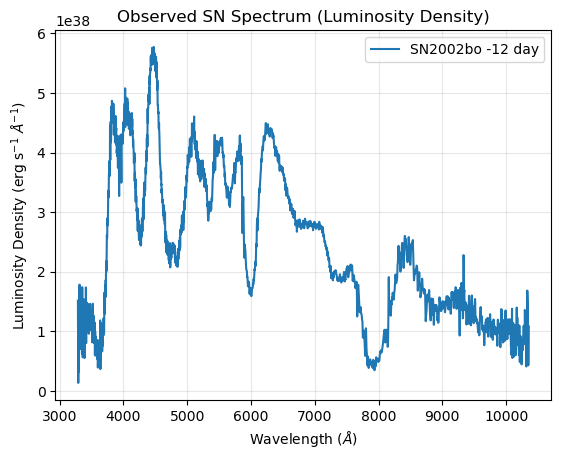

Luminosity density average: 2.39e+38


In [3]:
DISTANCE_OBSERVATION = 31.67 * u.Mpc
REDSHIFT = 0.0043

spec_obs = pd.read_csv(
    "configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat",
    header=None,
    sep=r"\s+",
    names=["wavelength", "flux"],
)
spec_obs["wavelength"] = spec_obs["wavelength"].values / (1 + REDSHIFT) * u.AA
spec_obs["flux"] = spec_obs["flux"].values * u.erg / (u.s * u.cm**2 * u.AA)

# Convert flux density to luminosity density
spec_obs["luminosity_density"] = (
    spec_obs["flux"] * 4 * np.pi * DISTANCE_OBSERVATION.to(u.cm) ** 2
)

plt.plot(
    spec_obs["wavelength"], spec_obs["luminosity_density"], label="SN2002bo -12 day"
)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)")
plt.title("Observed SN Spectrum (Luminosity Density)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Luminosity density average: {spec_obs['luminosity_density'].mean():.2e}")


# Run the simulation with the unmodified config

$\blacktriangleright$ run cell below.

In [4]:
# run the simulation with the base configuration
config_base = Configuration.from_yaml("configs_and_data/tardis_uniform_abundance.yml")
sim_base = run_tardis(
    config_base,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'62e3121a-a0cf-4f62-95b2-7e0eaee5b6e0': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '87c1e851-268f-47bc-8577-8b02b0b38a0a', …

# SDEC Plot with Observed Spectrum Overlay

$\blacktriangleright$ Make an SDEC plot and overplot the observed spectrum on top.

How does the luminosity density of the synthetic spectrum compare to the observed one? If they differ, how can we adjust the ejecta model parameters in the TARDIS configuration to better match the observation?


---
In this notebook, you will plot the comparison of the simulation SDEC plot with the observed spectrum quite many times. To make it more convenient, let's create a function to do this, taking the simulation object and the observed spectrum dataframe as input.



In [5]:
# #### uncomment the cell and fill in the missing parts
# def plot_SDEC_with_observations(sim, spec_obs, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 6))

#     # SDEC plot
#     plotter = SDECPlotter.from_simulation(sim)
#     plotter.generate_plot_mpl(
#         packets_mode="virtual",
#         packet_wvl_range=[3000, 10000] * u.AA,
#         ax=ax,
#     )

#     # plot the observed spectrum
#     ax.plot(???)
#     ax.grid(alpha=0.3)

# plot_SDEC_with_observations(sim_base, spec_obs)

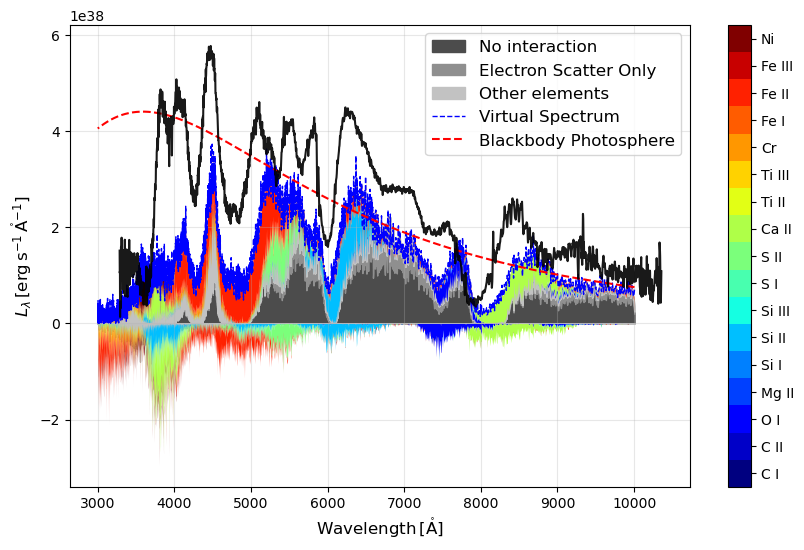

In [6]:
def plot_SDEC_with_observations(sim, spec_obs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # SDEC plot
    plotter = SDECPlotter.from_simulation(sim)
    plotter.generate_plot_mpl(
        packets_mode="virtual",
        packet_wvl_range=[3000, 10000] * u.AA,
        species_list=[
            "C I-III",
            "O I-III",
            "Mg I-III",
            "S I-III",
            "Si I-III",
            "Ca I-III",
            "Ti I-III",
            "Fe I-III",
            "Ar",
            "Cr",
            "Ni",
        ],
        ax=ax,
    )

    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        color="k",
        lw=1.5,
        alpha=0.9,
        label="SN2002bo -12 day",
    )
    ax.grid(alpha=0.3)


plot_SDEC_with_observations(sim_base, spec_obs)

# Changing Requested Luminosity 

You probably noticed that the synthetic spectral luminosity is lower than the observed spectrum. You guessed correctly that we can increase the `supernova.luminosity_requested` in the TARDIS config file to nudge it towards a higher value. 

For the purpose of matching the observed spectrum, if we are confident about the bolometric luminosity of the observed object, we can directly use that value as the starting point.

Based on [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract), SN2002bo has a UVOIR (UV + Optical + IR) luminosity of ~2e42 erg/s at the time when this spectrum was taken. 

$\blacktriangleright$ Update the luminosity_requested setting in the config, then run the simulation under the name `sim_match_L_SN`.

----

For exploring purpose, run another simulation named `sim_higher_L` with 3e42 erg/s as the luminosity, and compare the spectral features of these three simulations.

In [7]:
# ### uncomment the cell and fill in the value below to run the simulation with a luminosity matched with the observed spectrum
# print(config_base.supernova)
# config_match_L_SN = deepcopy(config_base)

# ### change the requested luminosity
# config_match_L_SN.supernova.luminosity_requested = ???

# print(config_match_L_SN.supernova)

# sim_match_L_SN = run_tardis(
#     config_match_L_SN,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )

$\blacktriangleright$ Run another simulation with higher luminosity (3e42 erg/s) using the name  `sim_higher_L`

In [8]:
# ### uncomment the cell and fill in the value below to run the simulation with a luminosity higher than the observed spectrum
# print(config_base.supernova)
# config_higher_L = deepcopy(config_base)

# ### change the requested luminosity
# config_higher_L.supernova.luminosity_requested = ???

# print(config_higher_L.supernova)

# sim_higher_L = run_tardis(
#     config_higher_L,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )

In [ ]:
print(config_base.supernova)
config_match_L_SN = deepcopy(config_base)

## change the requested luminosity
config_match_L_SN.supernova.luminosity_requested = 2e42 * u.erg / u.s

print(config_match_L_SN.supernova)

sim_match_L_SN = run_tardis(
    config_match_L_SN,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

{'luminosity_requested': <Quantity 1.2e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}
{'luminosity_requested': <Quantity 2.e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}


BokehModel(combine_events=True, render_bundle={'docs_json': {'62e3121a-a0cf-4f62-95b2-7e0eaee5b6e0': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '87c1e851-268f-47bc-8577-8b02b0b38a0a', …

In [ ]:
print(config_base.supernova)
config_higher_L = deepcopy(config_base)

### change the requested luminosity
config_higher_L.supernova.luminosity_requested = 3e42 * u.erg / u.s

print(config_higher_L.supernova)

sim_higher_L = run_tardis(
    config_higher_L,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Plot the spectral comparison of the observed spectrum vs all three simulations you ran above. Does the spectral continuum shape match better with the observed spectrum when matching the luminosity with the observed value?

Recall the components in the previous days and think about what changing the requested luminosity does under the hood of TARDIS: 

1. How does the **radiation field** change with luminosity?

2. How do the **plasma state** change with the radiation field?

3. Check the **ion contributions** and ionization states - how are they affected?

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
Higher luminosity means there are more energy escaped from the outer layer, which can be caused by less absorptions along the ejecta and/or higher temperature. Compare the t_inner (the inner boundary temperature, which defined the initial energy distribution of the packets) and t_radiative (the radiative temperature of each shell) within "sim.simulation_state" class.  Recall from day 2, the temperature affect the ionization and excitation balance, essentially determines the level number density that affects the tau sobolev optical depth. 
</details>


---
Similarly, let's make a function for comparing the simulation spectra to be used for future comparison as well. 

In [11]:
### uncomment the cell and fill in the missing parts
# def plot_spectral_comparison(simulations, spec_obs, ax=None, labels=None):
#     if ax is None:
#         fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#     # plot the observed spectrum
#     ax.plot(???)
#     for sim in simulations:
#         if labels is not None:
#             label = labels[sim]
#         else:
#             luminosity = ???
#             v_inner = ???
#             T_inner = ???
#             label = (
#                 f"L = {luminosity:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
#             )
#         # plot the simulated spectrum, ideally we should be using formal integral but due to time cost
#         # let's use the virtual packets
#         sim_wavelength = sim.spectrum_solver.spectrum_virtual_packets.wavelength
#         sim_luminosity_density = sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda ## or can use gaussian_filter1d to smooth it for plotting purposes
#         ax.plot(sim_wavelength, sim_luminosity_density, alpha=0.6, label=label)

#     ax.tick_params(axis="both", labelsize=12)
#     ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=14)
#     ax.set_ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)", fontsize=14)
#     ax.legend()
#     ax.grid(alpha=0.3)
#     ax.set_xlim(3000, 11000)

# simulations = [sim_base, sim_match_L_SN, sim_higher_L]
# plot_spectral_comparison(simulations, spec_obs)


In [ ]:
### comparison of spectra
def plot_spectral_comparison(simulations, spec_obs, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        label="Observed SN2002bo -12d",
        color="black",
        alpha=0.7,
        linewidth=1.5,
    )
    for i, sim in enumerate(simulations):
        if labels is not None:
            label = labels[i]
        else:
            luminosity = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {luminosity:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        sim_wavelength = sim.spectrum_solver.spectrum_virtual_packets.wavelength
        sim_luminosity_density = gaussian_filter1d(
            sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
            sigma=3,
        )
        ax.plot(sim_wavelength, sim_luminosity_density, alpha=0.6, lw=2, label=label)

    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=14)
    ax.set_ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)", fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(3000, 11000)


simulations = [sim_base, sim_match_L_SN, sim_higher_L]
plot_spectral_comparison(simulations, spec_obs)


$\blacktriangleright$ Compare the radiative temperature as a function of shell velocity for all above three simulations, and labels each one with the luminosity setting and converged T_inner value.


In [13]:
# your code here

In [ ]:
### comparison of the radiation field
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for sim in [sim_base, sim_match_L_SN, sim_higher_L]:
    label = f"L = {sim.luminosity_requested.to(u.erg / u.s):.2e}, T_inner = {sim.simulation_state.t_inner.to(u.K):.0f}"
    sim_velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    sim_t_radiative = sim.simulation_state.t_radiative.to(u.K)
    ax.plot(sim_velocity, sim_t_radiative, alpha=0.8, label=label)

ax.tick_params(axis="both", labelsize=12)
ax.set_xlabel(r"Velocity (km/s)", fontsize=14)
ax.set_ylabel(r"Radiative Temperature (K)", fontsize=14)
ax.set_title("Radiation Field Comparison: Effect of changing Luminosity", fontsize=14)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

$\blacktriangleright$ Run the cell below to show the SDEC plot comparison with the observed spectrum for all three simulations. 

---

**Changing the requested luminosity does NOT simply scales the spectrum up or down, but change the balance between the radiation field and plasma state.**

- **Temperature Structure Changes**: Higher luminosity increases the inner boundary temperature (T_inner) and radiative temperatures throughout the ejecta, see the radiative temperature comparison you plotted above. Recall from day 1, the T_inner determines the packet distribution initiated at the v_inner_boundary.

- **Ionization Balance Shifts**: Recall from Day 2 that temperature directly affects ionization equilibrium. Higher temperatures drive higher ionization states.

- **Line Opacity Modifications**: Recall from Day 2, the level number density affects the Sobolev optical depth for specific line transition.

For example, some of you might noticed in the Day 2 plasma exploration notebook that Ca II NIR triplets tau_Sobolev decrease with higher temperature (ionization/excitation balance shifts), and we see that effect as weaker Ca II NIR triplets feature in the synthetic spectrum.


In [15]:
# ## plot the SDEC plot, match the x and y range for better visual comparison
# fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=False)
# plot_SDEC_with_observations(sim_base, spec_obs, ax=axes[0])
# plot_SDEC_with_observations(sim_match_L_SN, spec_obs, ax=axes[1])
# plot_SDEC_with_observations(sim_higher_L, spec_obs, ax=axes[2])


# Estimate v_inner_boundary from observation 

Just like what we explored in the morning, the v_inner_boundary is an important setting in TARDIS. If the v_inner_boundary is set at a location far too inward or outward of the photosphere, the synthetical spectrum likely are not physical.

---

**Si II $\lambda\lambda$ 6355 as Photospheric Velocity Indicator?**

The Si II $\lambda\lambda$ 6355 absorption line is one of the most prominent features in Type Ia supernova spectra and serves as a key diagnostic for measuring photospheric expansion velocities in observational studies. The absorption minimum of this line provides an estimate of the velocity at which the photosphere is expanding.

**Velocity calcualton from absorption minima:**
$$v = c \times \frac{\lambda_{rest} - \lambda_{obs}}{\lambda_{rest}}$$

**Practical Application:**
For simulation purpose, this velocity estimate can serve as an educated guess for the `v_inner` boundary in TARDIS.

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. **Identify Si II absorption**: Locate the Si II $\lambda$ 6355 absorption minimum wavelength in the observed spectrum
2. **Calculate velocity**: Use the Doppler shift formula to estimate the expansion velocity  
3. **Apply as v_inner**: Use this velocity as a guess for the inner boundary and run the simulation 

---

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
The measured Si II velocity shoud be around 16550 km/s. 
</details>

In [16]:
# your code here to measure the observed Si II 6355 velocity

# expansion_velocity_km_s = xxx * u.km/u.s

Observed Si II 6355 absorption minimum: 6004.2 Angstrom
Estimated expansion velocity: 16550 km / s


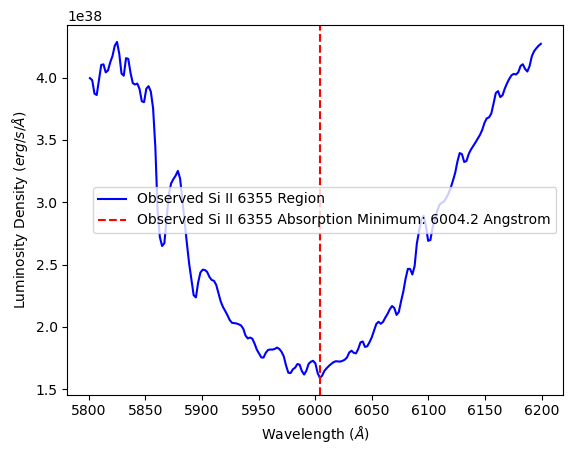

In [6]:
# Estimate v_inner from Si II 6355 absorption minimum
"""
Note that this is just a estimation. In observational studies, 
a more precise method is applied, in which the continuum is 
removed before measure the absorption minima.
"""
SI_II_REST_WAVELENGTH = 6355.0 * u.AA

# Find Si II 6355 absorption minimum in observed spectrum
si_region_mask = (spec_obs["wavelength"].values.value >= 5800) & (
    spec_obs["wavelength"].values.value <= 6200
)
si_region_flux = spec_obs["luminosity_density"][si_region_mask]
si_region_wavelength = spec_obs["wavelength"][si_region_mask]

# Find absorption minimum (lowest flux point)
min_flux_index = np.argmin(si_region_flux)
observed_si_wavelength = si_region_wavelength.iloc[min_flux_index]

plt.plot(si_region_wavelength, si_region_flux, "b-", label="Observed Si II 6355 Region")
plt.axvline(
    observed_si_wavelength.value,
    color="r",
    linestyle="--",
    label=f"Observed Si II 6355 Absorption Minimum: {observed_si_wavelength:.1f}",
)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Luminosity Density ($erg/s/\AA$)")
plt.legend()

# Calculate expansion velocity from Doppler shift
expansion_velocity = (
    const.c * (SI_II_REST_WAVELENGTH - observed_si_wavelength) / SI_II_REST_WAVELENGTH
)
expansion_velocity_km_s = expansion_velocity.to(u.km / u.s)

print(f"Observed Si II 6355 absorption minimum: {observed_si_wavelength:.1f}")
print(f"Estimated expansion velocity: {expansion_velocity_km_s:.0f}")


$\blacktriangleright$ Apply this new v_inner_boundary value in the config and run the simulation 

In [18]:
# ### uncomment the cell and fill in the missing parts
# print(
#     f"Previous v_inner: {config_match_L_SN.model.structure.velocity.start.to(u.km / u.s):.0f}"
# )
# config_change_v_inner = deepcopy(config_match_L_SN)
# # Apply the physics-based estimate of v_inner
# config_change_v_inner.model.structure.velocity.start = ???
# print(
#     f"New v_inner (from Si II): {config_change_v_inner.model.structure.velocity.start.to(u.km / u.s):.0f}"
# )

# sim_change_v_inner = run_tardis(
#     config_change_v_inner,
#     virtual_packet_logging=True,
#     show_convergence_plots=False,
#     export_convergence_plots=False,
#     log_level="INFO",
# )


In [ ]:
print(
    f"Previous v_inner: {config_match_L_SN.model.structure.velocity.start.to(u.km / u.s):.0f}"
)
config_change_v_inner = deepcopy(config_match_L_SN)
# Apply the physics-based estimate of v_inner
config_change_v_inner.model.structure.velocity.start = expansion_velocity_km_s
print(
    f"New v_inner (from Si II): {config_change_v_inner.model.structure.velocity.start.to(u.km / u.s):.0f}"
)

sim_change_v_inner = run_tardis(
    config_change_v_inner,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)


Previous v_inner: 12900 km / s
New v_inner (from Si II): 16550 km / s


$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

**Compare results**: See how this observation-inferred estimation compares to previous choices of v_inner.

How do the dilution factors change? Does the starting shell reach a dilution factor of 0.5?  

How does the spectrum differ from the previous simulations. and from the observed spectrum?


In [ ]:
### uncomment the cell and fill in the missing parts

# def plot_dilution_factor(simulations, ax=None, labels=None):
#     for i, sim in enumerate(simulations):
#         velocity = ???
#         W = ???
#         if labels is not None:
#             label = labels[sim]
#         else:
#             luminosity = sim.results["luminosity"]
#             v_inner = sim.results["v_inner"]
#             T_inner = sim.results["T_inner"]
#             label = f"L = {lum:.2e} erg/s, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
#         ax.plot(
#             velocity,
#             W,
#             alpha=0.8,
#             label=label,
#         )

# fig, axes = plt.subplots(3, 1, figsize=(12, 16))
# plt.subplots_adjust(hspace=0.4)

# # plot SDEC with the new v_inner
# plot_SDEC_with_observations(sim_change_v_inner, spec_obs, ax=axes[0])

# sim_s = [sim_base, sim_match_L_SN, sim_change_v_inner]
# # compare the spectra with all previous simulations
# plot_spectral_comparison(sim_s, spec_obs, ax=axes[1])

# # plot the optical depth current simulation and the one the base config(see the notebook in the morning)
# plot_dilution_factor(sim_s, ax=axes[2])

In [ ]:
def plot_dilution_factor(simulations, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, sim in enumerate(simulations):
        velocity = sim.simulation_state.v_inner.to(u.km / u.s)
        W = sim.simulation_state.dilution_factor
        if labels is not None:
            label = labels[i]
        else:
            # Use the requested luminosity, v_inner, and T_inner from the simulation state
            lum = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {lum:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        ax.plot(
            velocity,
            W,
            alpha=0.8,
            label=label,
        )
    ax.axhline(
        y=0.5,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="W = 0.5 (photosphere)",
    )
    ax.set_xlabel("Velocity (km/s)")
    ax.set_ylabel("Dilution Factor (W)")
    ax.set_title("Dilution Factor Comparison")
    ax.legend()
    ax.grid(alpha=0.3)


fig, axes = plt.subplots(3, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# plot SDEC with the new v_inner
plot_SDEC_with_observations(sim_change_v_inner, spec_obs, ax=axes[0])

sim_s = [sim_base, sim_match_L_SN, sim_change_v_inner]
# compare the spectra with all previous simulations
plot_spectral_comparison(sim_s, spec_obs, ax=axes[1])

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, ax=axes[2])



---

Before we move on, let's assess the current spectral match:
- Are the absorption line positions of Si II matching the observed spectrum?  
- How about the spectral line profiles of other ions (such as S II, Ca II)?
- Which feature has the biggest discrepancy between the synthetic and observed spectra?

**What's next?**: Let's hold v_inner constant for now and systematically explore how other parameters (density, abundance) affect the spectrum before making further adjustments to v_inner.

---

**Key Insight: Parameterized vs. Hydro Models**

Unlike the post-processing workflow with hydro models, parameterized models offer more flexibility but also more complexity:

- **Multiple free parameters**: Luminosity, v_inner, density profile, elemental mass fractions can all be adjusted. It's not constrained by a specific model structure.
- **Parameter degeneracies**: Different combinations of parameters can produce similar spectral features.

**Observations Provide Ejecta Property Estimates**

Although the number of free parameters is quite large when exploring these parameterized models, fortunately the observational data that we are trying to match can narrow down some of the parameter ranges! 

$\blacktriangleright$ Just like how we estimated the photospheric velocity using the Si II absorption feature in the above section, **are there other photospheric properties we can interpret from the observations?**

---

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
From observations of photometric colors and spectral ionization ratios (such as Fe II vs Fe III), we can estimate the photospheric temperature. 
<a href="https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract">Benetti et al. 2014</a> estimate the photospheric temperature of SN2002bo at early times to be on the order of 9500 K. Check what is the T_inner (sim_change_v_inner.simulation_state.t_inner) of the TARDIS simulation you ran above and think from first principles: what can increase or decrease the T_inner? What parameters can we tune in the ejecta model? 
</details>


In [ ]:
# your code here to diagnose the simulation_state

In [ ]:
# check T_inner, this is not really the photospheric temperature,
# the T_inner in TARDIS should be slightly higher than the effective photospheric temperature
sim_change_v_inner.simulation_state.t_inner

**Create Photospheric Conditions**

By checking the inner temperature ($T_{inner}$) of the above simulation, it is lower than the value inferred from [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract) (~9500 K). 

$\blacktriangleright$ Assuming we would like to keep the measured Si II 6355 absorption velocity as the v_inner_boundary in TARDIS, what other parameters can we adjust to increase the $T_{inner}$ at this velocity and why? 

---

Since the simulation converge on an output luminosity close to the same luminosity requested, if $T_{inner}$ increase but the output energy is the same, which means the ejecta is absorbing more energy -- an ejecta with larger optical depth (or dilution factor).

$\blacktriangleright$ **What parameters in the ejecta model can we modify to increase the optical depth?**

---

<details>
<summary><strong>💡 <u>Click here for Hint</u> </strong></summary>
Increasing the number density of ions increases the optical depth. If you want larger opacity for specific ions (stronger features), you can increase the mass fraction of that element. If you want to increase the continuum opacity, then scaling up the density profile will increase the optical depth as a whole.  
</details>

----

**Let's increase the density with the goal of driving up the dilution factor at the v_inner_boundary to around 0.5 (photospheric condition)!**

⚠️ **WARNING** ⚠️ Make sure the dilution factors are within [0,1], otherwise the TARDIS simulation will not be physical. 
</details>

<font size=+3>&#9998;</font> Double click this cell to write your answer here.

# Exploring the Density Profile

The number density of matter is strongly controlled by the density structure, which then affects the optical depth and photosphere location. 

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

<u>**Figure out how many free parameters there are to determine a unique density profile**</u>

**Assumptions**: 

The parameters that can affect the density profile under a power-law assumption are: 
- $t$: `config.supernova.time_explosion`
- $\rho_0$: `config.model.structure.density.rho_0`
- $t_0$: `config.model.structure.density.time_0`
- $v_0$: `config.model.structure.density.v_0` 
- $\alpha$: `config.model.structure.density.exponent`

For power-law density: $\rho(v) = \rho_0 (v/v_0)^{\alpha}$, and for homologous expansion: $\rho(t) = \rho (t_0/t)^3$, hence we have:

$$\rho(v) = \rho_0 (v/v_0)^{\alpha} (t_0/t)^{3}$$

<font size=+3>&#9998;</font> Double click this cell to write your answer here.


---
## Change time and rho_0
$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. Calculate the $\rho_0'$ so that 
$$\rho(v) = \rho_0 (v/v_0)^{\alpha} (t_0/8day)^{3} = \rho_0' (v/v_0)^{\alpha} (t_0/5day)^{3}$$
2. Run the following two simulation in order to increase the density:
- Deepcopy `config_change_v_inner` as `config_change_time_explosion`, set the `time_explosion` to be 5 days, and run `sim_change_time_explosion` 
- Deepcopy `config_change_v_inner` as `config_change_rho_0`, set the `density.rho_0` to be $\rho_0'$ g/$cm^3$, and run `sim_change_rho_0`.



In [ ]:
# your code here to run two simulation with one change time one change initial density

$\blacktriangleright$ Use the comparison function you made to analyze the spectrum and dilution factors. 

In [ ]:
# your code here to perform the comparison

In [ ]:
### run two simulation with one change time one change initial density

# change time explosion
config_change_time_explosion = deepcopy(config_change_v_inner)
config_change_time_explosion.time_explosion = 5 * u.day

sim_change_time_explosion = run_tardis(
    config_change_time_explosion,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

# change rho_0
new_rho_0 = (
    (config_change_v_inner.supernova.time_explosion.to(u.day).value / 5) ** 3
    * 1e-11
    * u.g
    / u.cm**3
)  # scale the rho_0 to match the density profile
config_change_rho_0 = deepcopy(config_change_v_inner)
config_change_rho_0.model.structure.density.rho_0 = new_rho_0

sim_change_rho_0 = run_tardis(
    config_change_rho_0,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# plot SDEC
plot_SDEC_with_observations(sim_change_time_explosion, spec_obs, ax=axes[0])
plot_SDEC_with_observations(sim_change_rho_0, spec_obs, ax=axes[1])

sim_s = [sim_change_time_explosion, sim_change_rho_0]
labels = ["change time_explosion", "change rho_0"]
# compare the spectra with previous simulations
plot_spectral_comparison(sim_s, spec_obs, ax=axes[2], labels=labels)

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, ax=axes[3], labels=labels)


That is a very different outcome even though these two simulations have the "same" density profile (and abundance too)!

Link what you learned on Day 2 about plasma: how does time affect the sobolev optical depth in SN ejecta? 

**Connection to Day 1 and Day 2 Concepts:**
Recall from the Radiative Transfer and plasma introduction on Days 1 and 2, the Sobolev optical depth under LTE and homologous expansion assumptions is:

$$
\tau_{\rm Sob} = \sigma_{\nu} \, n_l \, t_{\exp} \, \lambda_{\rm line}
$$

This shows the explicit dependence on $t_{\exp}$ (time since explosion), which directly affects the line optical depths and thus the spectrum, even when the velocity-space density profile appears identical. The physical size of the ejecta and the plasma conditions are fundamentally different between these two cases.

This shows  why changing the time since explosion in a supernova ejecta model is more than just rescaling the density — **and not a self-similar transformation** — we must distinguish between homologous expansion kinematics and the radiation–plasma coupling.

## Change Initial Density

Now let's come back to the question and goal of this section (creating photospheric conditions). The question we were trying to answer was:

**How many free parameters are there to determine a unique density profile?**

From the above test cases, we know that the time since explosion $t$ should be treated as an independent parameter when determining the density profile. Although in velocity space, we can sometimes produce the "same" density by adjusting both $t$ and $\rho_0$, it fundamentally changes the density profile (e.g., in radius) and the matter state. 

What about the rest of the parameters? We usually can fix $v_0$ and $t_0$ as static reference points, so the free parameters to determine a unique density structure in an SN ejecta under the assumption of power-law are:
- $\rho_0$: initial density at the reference point 
- $\alpha$: the power-law exponent

---
$\blacktriangleright$ **<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Following the control variable principle, let's first try changing $\rho_0$ to increase the density, so as to nudge up the dilution factor to around 0.5 in order to create a photospheric condition. 

Monitor the dilution factor for the simulations that you try. 

In [ ]:
### uncomment the cell and fill in the missing parts
# # Modify initial density to increase optical depth
# RHO_0_NEW = ??? * u.g / u.cm**3

# config_change_rho_0_iter_2 = deepcopy(config_change_v_inner)
# config_change_rho_0_iter_2.model.structure.density.rho_0 = RHO_0_NEW

# print(f"Original rho_0: {config_change_v_inner.model.structure.density.rho_0}")
# print(f"New rho_0: {RHO_0_NEW}")

# sim_change_rho_0_iter_2 = run_tardis(
#     config_change_rho_0_iter_2,
#     virtual_packet_logging=True,
#     show_convergence_plots=False,
#     export_convergence_plots=False,
#     log_level="INFO",
# )


In [ ]:
### uncomment the cell and run to compare the dilution factors
# sim_s = [sim_change_v_inner, sim_change_rho_0, sim_change_rho_0_iter_2]
# labels = ["match v_inner", "change rho_0", "change rho_0_iter_2"]

# # compare the spectra with previous simulations
# plot_spectral_comparison(sim_s, spec_obs, labels=labels)

# # plot the dilution factors
# plot_dilution_factor(sim_s, labels=labels)


$\blacktriangleright$ Repeat the above step if necessary, the goal to find a $rho_0$ value that makes the first shell dilution factor to be around 0.5

In [21]:
# Modify initial density to increase optical depth
RHO_0_NEW = 9e-11 * u.g / u.cm**3

config_change_rho_0_iter_2 = deepcopy(config_change_v_inner)
config_change_rho_0_iter_2.model.structure.density.rho_0 = RHO_0_NEW

print(f"Original rho_0: {config_change_v_inner.model.structure.density.rho_0}")
print(f"New rho_0: {RHO_0_NEW}")

sim_change_rho_0_iter_2 = run_tardis(
    config_change_rho_0_iter_2,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)


Original rho_0: 1e-11 g / cm3
New rho_0: 9e-11 g / cm3


TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

In [ ]:
sim_s = [sim_change_v_inner, sim_change_rho_0, sim_change_rho_0_iter_2]
labels = ["match v_inner", "change rho_0", "change rho_0_iter_2"]
# compare the spectra with previous simulations
plot_spectral_comparison(sim_s, spec_obs, labels=labels)

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, labels=labels)


$\blacktriangleright$ How does increasing the density profile (with same shape) change the spectra and dilution factor in this simulation?

<font size=+3>&#9998;</font> Double click this cell to write your answer here.

## Change Density Exponent 

Let's play with how the steepness of the density profile affect the simulation. 

$\blacktriangleright$ First run the cell below to see the current set up of the density profile, and think about how the density profile will change if we just change the power law exponent? 

$\blacktriangleright$ If we would like to the follow the control variable principle as much as we can (relative to the previous simulation), how would you change the way of defining the power law density profile? 


In [12]:
config_for_exponent = deepcopy(config_change_rho_0_iter_2)
config_for_exponent.model.structure

{'type': 'specific',
 'velocity': {'start': <Quantity 16549.58069813 km / s>,
  'stop': <Quantity 25000. km / s>,
  'num': 20},
 'density': {'type': 'power_law',
  'rho_0': <Quantity 9.e-11 g / cm3>,
  'time_0': <Quantity 5. d>,
  'v_0': <Quantity 8000. km / s>,
  'exponent': -7}}

In the current configuration, the density profile is defined using the reference velocity of 8000 km/s and the v_inner_boundary currently is set to be a value ~16000 km/s.  If we change the exponent in this configuration, the density profile above the v_inner_boundary would deviates in not only exponent, also the density at v_inner and the total eject mass. 

---

To control the variable in this case, we could try
- 1. Move the reference initial density value to be at the v_inner_boundary to keep the initial density at that location conserved. 
- 2. Calculate the mass between the v_inner_boundary and v_outer_boundary, and change the initial density accordingly to conserve the mass. 


--- 

### Conserve the density at v_inner_boundary

Let' try the first case first -- change the reference v_0 to be at the v_inner_boundary. 

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. Calculate the $\rho_0'$ so that 

$$\rho(v) = \rho_0 \,(\frac{v}{v_0})^{\alpha}\, (\frac{t_0}{t})^{3} = \rho_0'\, (\frac{v}{v_\text{inner boundary}})^{\alpha} \,(\frac{t_0}{t})^{3}$$

2. Copy and modify the config:
Deepcopy the `config_change_v_inner` as `config_change_exponent`, update the density `v_0` and  `rho_0` with the equivalent values. Update the density exponent down to -4 in order to increase the density. 

3. Run simulation `sim_change_exponent` with the `config_change_exponent` config. 

4. Repeat the above steps with an exponent value smaller (steeper) than the original value (-7).

5. Compare the results.

In [ ]:
# #### Uncomment this cell and fille in the value
# ## Calculate equivalent rho_0 at v_inner_boundary
# v_inner_boundary = ???
# rho_0_at_v_inner = ???

# ## Update the configuration with new rho_0
# config_for_exponent.model.structure.density.rho_0 = rho_0_at_v_inner
# config_for_exponent.model.structure.density.v_0 = V_INNER_BOUNDARY

# ## run the simulation with the new density profile
# new_exponent = ???
# config_change_exponent = deepcopy(config_for_exponent)
# config_change_exponent.model.structure.density.exponent = new_exponent

# sim_change_exponent = run_tardis(
#     config_change_exponent,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )

In [ ]:
# you code here for the next steps

In [ ]:
# Step 1: Calculate equivalent rho_0 at v_inner_boundary and update configuration
# Current: rho(v) = rho_0 * (v/8000)^α
# Target:  rho(v) = rho_0' * (v/v_inner)^α
# At v_inner: rho_0 * (v_inner/8000)^α = rho_0' * (v_inner/v_inner)^α = rho_0'

V_0_ORIGINAL = config_for_exponent.model.structure.density.v_0
RHO_0_ORIGINAL = config_for_exponent.model.structure.density.rho_0
ALPHA_ORIGINAL = config_for_exponent.model.structure.density.exponent
V_INNER_BOUNDARY = config_for_exponent.model.structure.velocity.start

# Calculate equivalent rho_0 at v_inner_boundary
rho_0_at_v_inner = RHO_0_ORIGINAL * (V_INNER_BOUNDARY / V_0_ORIGINAL) ** ALPHA_ORIGINAL

# Update the configuration with new rho_0
config_for_exponent.model.structure.density.rho_0 = rho_0_at_v_inner
config_for_exponent.model.structure.density.v_0 = V_INNER_BOUNDARY

print(f"Original reference: v_0 = {V_0_ORIGINAL}, rho_0 = {RHO_0_ORIGINAL}")
print(f"New reference: v_0 = {V_INNER_BOUNDARY:.0f}, rho_0 = {rho_0_at_v_inner:.2e}")

In [ ]:
# Step 2 & 3: Create configurations with different exponents and run simulations

# larger Exponent (less steep, higher density)
config_change_exponent = deepcopy(config_for_exponent)
config_change_exponent.model.structure.density.exponent = -4

sim_change_exponent = run_tardis(
    config_change_exponent,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)


# Smaller Exponent (steeper, lower density)
config_change_exponent_iter2 = deepcopy(config_change_exponent)
config_change_exponent_iter2.model.structure.density.exponent = -11

sim_change_exponent_iter2 = run_tardis(
    config_change_exponent_iter2,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)

In [ ]:
# Step 5: Compare the results
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# List of simulations for comparison
sim_exponent_list = [
    sim_change_exponent,
    sim_change_rho_0_iter_2,
    sim_change_exponent_iter2,
]
exponent_labels = [
    "Exponent = -4 (less steep)",
    "Exponent = -7 (moderate)",
    "Exponent = -11 (steeper)",
]

# Compare spectra
plot_spectral_comparison(
    sim_exponent_list, spec_obs, ax=axes[0], labels=exponent_labels
)
axes[0].set_title("Spectral Comparison: Effect of Density Exponent (conversing density at v_inner_boudnary)")

# Compare dilution factors
plot_dilution_factor(sim_exponent_list, ax=axes[1], labels=exponent_labels)
axes[1].set_title("Dilution Factor Comparison: Effect of Density Exponent (conversing density at v_inner_boudnary)")

# Plot density profiles for comparison
for i, sim in enumerate(sim_exponent_list):
    velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    density = sim.simulation_state.density.to(u.g / u.cm**3)
    W_first_shell = sim.simulation_state.dilution_factor[0]
    axes[2].plot(velocity, density, alpha=0.8, label=exponent_labels[i]+f" (W={W_first_shell:.2f})")

axes[2].set_xlabel("Velocity (km/s)")
axes[2].set_ylabel("Density (g/cm³)")
axes[2].set_title("Density Profile Comparison: Effect of Exponent")
axes[2].legend()
axes[2].set_yscale("log")
axes[2].grid(alpha=0.3)

---

### Conserve the total mass

Let's try the second case, conserving the mass between the velocity boundaries.

**Mass Conservation in Power-Law Density Profiles**

For a spherically symmetric ejecta in homologous expansion, the mass contained between a certain velocity range ($v_{\rm inner}$ and $v_{\rm outer}$) can be calculated by integrating the density profile:

$$M=\iiint \rho r^2 d r d \phi d \theta \sin \theta$$

since $r=v t$ in homolougous expansion, so $d r=t d v$.

$$M = \int_{v_{\rm inner}}^{v_{\rm outer}} \rho(v) \cdot 4\pi v^2 t^3 \, dv$$

For our power-law density profile:
$$\rho(v) = \rho_0 \left(\frac{v}{v_0}\right)^{\alpha} \left(\frac{t_0}{t}\right)^3$$

Substituting these into the mass integral:
$$M = 4\pi t^3 \rho_0 \left(\frac{t_0}{t}\right)^3 v_0^{-\alpha} \int_{v_{\rm inner}}^{v_{\rm outer}} v^{\alpha + 2} \, dv$$

$$M = 4\pi t_0^3 \rho_0 v_0^{-\alpha} \int_{v_{\rm inner}}^{v_{\rm outer}} v^{\alpha + 2} \, dv$$

Evaluating the integral:
$$M = 4\pi t_0^3 \rho_0 v_0^{-\alpha} \left[\frac{v^{\alpha + 3}}{\alpha + 3}\right]_{v_{\rm inner}}^{v_{\rm outer}}$$

$$M = \frac{4\pi t_0^3 \rho_0 v_0^{-\alpha}}{\alpha + 3} \left(v_{\rm outer}^{\alpha + 3} - v_{\rm inner}^{\alpha + 3}\right)$$

**Key Insight**: For $\alpha < -3$, the mass is dominated by the inner boundary, while for $\alpha > -3$, the outer boundary dominates.

**Mass Conservation Strategy**: When changing the exponent $\alpha \rightarrow \alpha'$, we can calculate the new $\rho_0'$ that preserves the total ejecta mass:

$$\frac{\rho_0'}{\rho_0} = \frac{v_0^{\alpha'}(\alpha' + 3)(v_{\rm outer}^{\alpha + 3} - v_{\rm inner}^{\alpha + 3})}{v_0^{\alpha}(\alpha + 3)(v_{\rm outer}^{\alpha' + 3} - v_{\rm inner}^{\alpha' + 3})}$$

This ensures that changing the density profile steepness doesn't artificially change the total mass within the ejecta within the velocity range.


---

$\blacktriangleright$**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. Define a new exponent $\alpha'$ ($\alpha'$ > -7) and Calculate the $\rho_0'$ following the mass conservation method above

2. Copy and modify the config:
Deepcopy the `config_change_v_inner` as `config_change_exponent_M2`, update the density configuration using value in the above step.

3. Run simulation `sim_change_exponent_M2` with the `config_change_exponent_M2` config. 

4. Repeat the above steps with an exponent value smaller (steeper) than the original value (-7).

5. Compare the results.

In [ ]:
# #### Uncomment this cell and fill in the value
# ## write a function to calculate new rho_0 given new_exponent 
# def calculate_mass_conserving_rho_0(config, new_exponent):
#     """
#     Calculate new rho_0 that preserves total ejecta mass when changing density exponent.

#     Parameters:
#     -----------
#     config : Configuration object
#         TARDIS configuration with current density profile
#     new_exponent : float
#         New density profile exponent

#     Returns:
#     --------
#     new_rho_0 : astropy.Quantity
#         New initial density that preserves total mass
#     """
#     # Get current parameters
#     v_inner = config.model.structure.velocity.start.to(u.km / u.s)
#     v_outer = config.model.structure.velocity.stop.to(u.km / u.s)
#     v_0 = config.model.structure.density.v_0.to(u.km / u.s)
#     rho_0_old = config.model.structure.density.rho_0
#     alpha_old = config.model.structure.density.exponent
#     alpha_new = new_exponent

#     # Calculate new rho_0 to preserve mass
#     rho_0_new = ???

#     print(f"Original: exponent = {alpha_old:.1f}, rho_0 = {rho_0_old:.2e}")
#     print(f"New:      exponent = {alpha_new:.1f}, rho_0 = {rho_0_new:.2e}")
#     print(f"Scaling factor: {mass_factor_old / mass_factor_new:.3f}")

#     return rho_0_new

# ## Update the configuration with new exponent and new rho_0
# config_change_exponent_M2 = deepcopy(config_for_exponent)

# # Case 1: Less steep exponent with mass conservation
# new_alpha = ???
# new_rho_0 = calculate_mass_conserving_rho_0(config_change_exponent_M2, new_alpha)

# config_change_exponent_M2.model.structure.density.exponent = new_alpha
# config_change_exponent_M2.model.structure.density.rho_0 = new_rho_0

# sim_change_exponent_M2 = run_tardis(
#     config_change_exponent_M2,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )

In [ ]:
# your code here for the next steps

In [ ]:
# Mass-conserving approach: Calculate new rho_0 to preserve total ejecta mass
def calculate_mass_conserving_rho_0(config, new_exponent):
    """
    Calculate new rho_0 that preserves total ejecta mass when changing density exponent.

    Parameters:
    -----------
    config : Configuration object
        TARDIS configuration with current density profile
    new_exponent : float
        New density profile exponent

    Returns:
    --------
    new_rho_0 : astropy.Quantity
        New initial density that preserves total mass
    """
    # Get current parameters
    v_inner = config.model.structure.velocity.start.to(u.km / u.s)
    v_outer = config.model.structure.velocity.stop.to(u.km / u.s)
    v_0 = config.model.structure.density.v_0.to(u.km / u.s)
    rho_0_old = config.model.structure.density.rho_0
    alpha_old = config.model.structure.density.exponent
    alpha_new = new_exponent

    # Calculate mass scaling factor
    mass_factor_old = v_0**alpha_old *(alpha_old + 3) / (v_outer ** (alpha_old + 3) - v_inner ** (alpha_old + 3))
    mass_factor_new = v_0**alpha_new * (alpha_new + 3) / (v_outer ** (alpha_new + 3) - v_inner ** (alpha_new + 3))

    # Calculate new rho_0 to preserve mass
    rho_0_new = rho_0_old * (mass_factor_new / mass_factor_old)

    print(f"Original: exponent = {alpha_old:.1f}, rho_0 = {rho_0_old:.2e}")
    print(f"New:      exponent = {alpha_new:.1f}, rho_0 = {rho_0_new:.2e}")
    print(f"Scaling factor: {mass_factor_old / mass_factor_new:.3f}")

    return rho_0_new


# Test with different exponents while conserving mass
config_change_exponent_M2 = deepcopy(config_for_exponent)

# Case 1: Less steep exponent (α = -4) with mass conservation
new_alpha = -4
new_rho_0 = calculate_mass_conserving_rho_0(config_change_exponent_M2, new_alpha)

config_change_exponent_M2.model.structure.density.exponent = new_alpha
config_change_exponent_M2.model.structure.density.rho_0 = new_rho_0

sim_change_exponent_M2 = run_tardis(
    config_change_exponent_M2,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

# Case 2: Steeper exponent (α = -10) with mass conservation
config_change_exponent_M2_itr2 = deepcopy(config_for_exponent)
new_alpha_2 = -10
new_rho_0_2 = calculate_mass_conserving_rho_0(config_change_exponent_M2_itr2, new_alpha_2)

config_change_exponent_M2_itr2.model.structure.density.exponent = new_alpha_2
config_change_exponent_M2_itr2.model.structure.density.rho_0 = new_rho_0_2

sim_change_exponent_M2_itr2 = run_tardis(
    config_change_exponent_M2_itr2,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)

Original: exponent = -7.0, rho_0 = 9.00e-11 g / cm3
New:      exponent = -4.0, rho_0 = 6.07e-12 g / cm3
Scaling factor: 14.815


BokehModel(combine_events=True, render_bundle={'docs_json': {'b7cb9235-ac58-4bd2-a9b9-9ce17778787e': {'version…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '9088727a-8a32-47ff-af01-64e1b7ea41e8', …

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

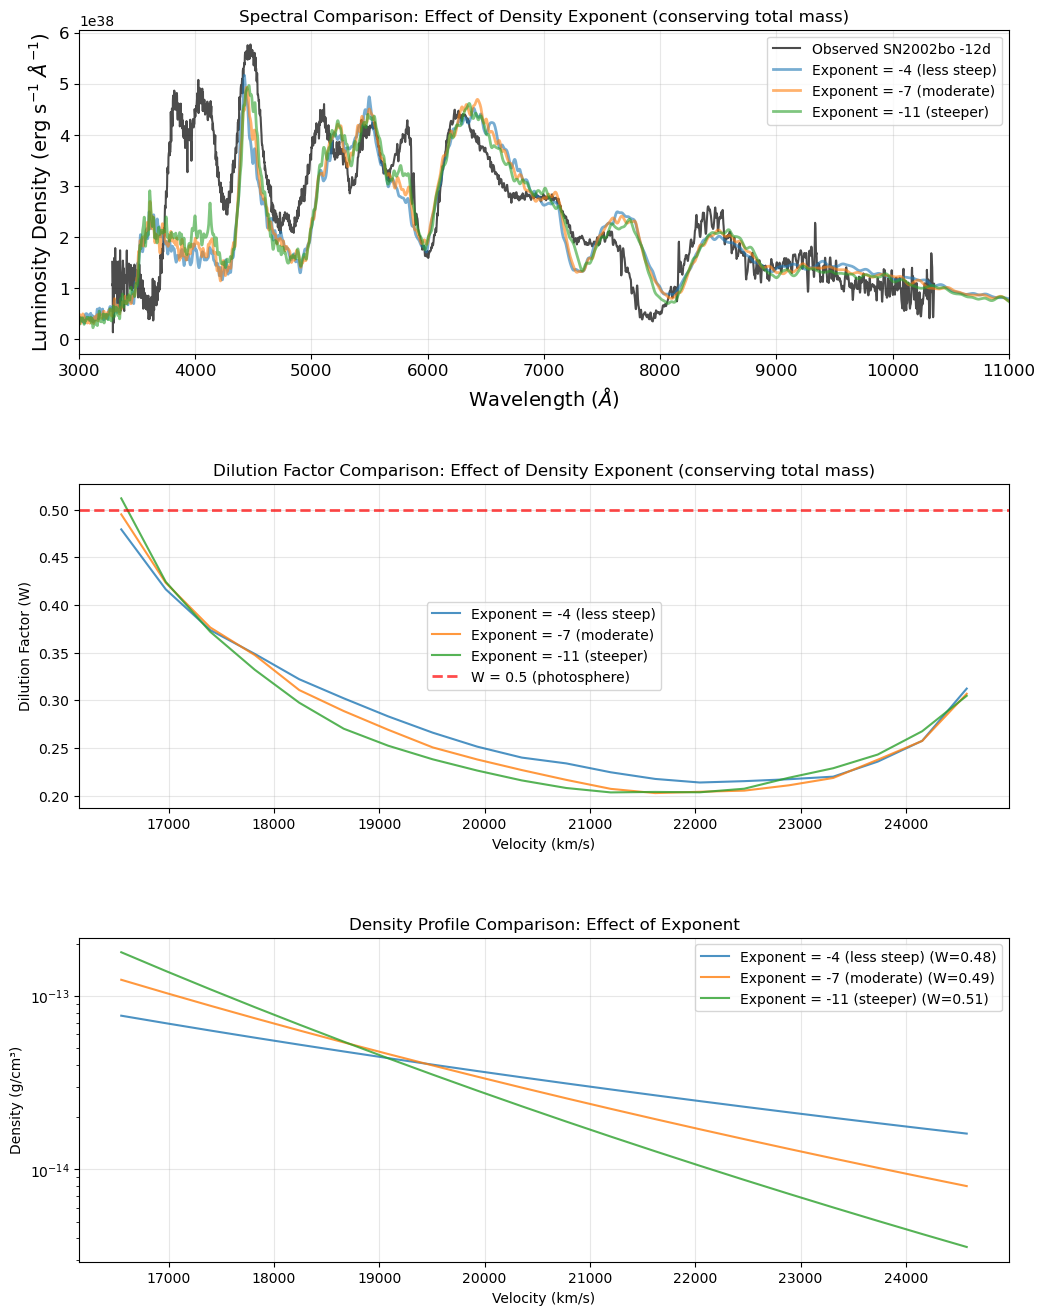

In [27]:
## Compare the results of this method
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# List of simulations for comparison
sim_exponent_list = [
    sim_change_exponent_M2,
    sim_change_rho_0_iter_2,
    sim_change_exponent_M2_itr2,
]
exponent_labels = [
    "Exponent = -4 (less steep)",
    "Exponent = -7 (moderate)",
    "Exponent = -11 (steeper)",
]

# Compare spectra
plot_spectral_comparison(
    sim_exponent_list, spec_obs, ax=axes[0], labels=exponent_labels
)
axes[0].set_title("Spectral Comparison: Effect of Density Exponent (conserving total mass)")

# Compare dilution factors
plot_dilution_factor(sim_exponent_list, ax=axes[1], labels=exponent_labels)
axes[1].set_title("Dilution Factor Comparison: Effect of Density Exponent (conserving total mass)")

# Plot density profiles for comparison
for i, sim in enumerate(sim_exponent_list):
    velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    density = sim.simulation_state.density.to(u.g / u.cm**3)
    W_first_shell = sim.simulation_state.dilution_factor[0]
    axes[2].plot(velocity, density, alpha=0.8, label=exponent_labels[i]+f" (W={W_first_shell:.2f})")

axes[2].set_xlabel("Velocity (km/s)")
axes[2].set_ylabel("Density (g/cm³)")
axes[2].set_title("Density Profile Comparison: Effect of Exponent")
axes[2].legend()
axes[2].set_yscale("log")
axes[2].grid(alpha=0.3)

**How does the spectrum changes with the change in density exponent?**

Is there change in major ion contributions? How about absorption feature velocity?

---

$\blacktriangleright$ Surprisingly, the change of density exponent does not affect the spectrum for this specific simulation, but this is not always the case, think of a simulation has a later time_explosion and further inward v_inner_boundary, how would that change and why? 

(You could run a test simulation to verify. )

---

# Summary

In this notebook, we explored how the ejecta model parameters affect synthetic spectra in TARDIS following the principle of control variable:

**Key Parameters Investigated:**
- **Luminosity**: Strongly affect the radiation field intensity and plasma state
- **Inner velocity boundary**: Estimated v inner boundary from the observed spectrum (did not fine tune)
- **Time since explosion**: (Is not a self-similar parameter) Affect the ejecta geometry and Sobolev optical depth.  
- **Density profile**: Determine the elemental density, which affects the radiational field balance, hence the level number density that determines the Sobolev optical depth. 

**Key Physical Insights:**
- Changing luminosity doesn't simply scale spectra but alters balance between radiation field and plasma.
- Observational constraints (Si II velocity, photospheric temperature) provide physical initial guesses for model parameters
- Power law density structure can be determined through 2 free parameter given the same time since explosion. 

**Observational Connections:**
- Used SN2002bo spectrum at -12 days relative to peak as object of interest. 
- Applied flux-to-luminosity density conversion for direct comparison with TARDIS output
- Estimated photospheric velocity from absorption line Doppler shifts of Si II $\lambda\lambda$6355

---

# Well Done and Take a Break! 

**Coming up in Notebook 4**: We'll dive into elemental abundance effects, exploring how individual elements control specific spectral features and ionization balance as a whole in spectrum. 

In [1]:
from IPython import get_ipython
from pathlib import Path

ip = get_ipython()
path = None
if "__vsc_ipynb_file__" in ip.user_ns:
    path = ip.user_ns["__vsc_ipynb_file__"]

nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace("instructor", "student")

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --ClearOutputPreprocessor.enabled=True --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")

/Users/jing/mambaforge/bin/jupyter-nbconvert:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  from nbconvert.nbconvertapp import main
[NbConvertApp] Converting notebook 3_explore_parametrized_models_part1_instructor.ipynb to notebook
[NbConvertApp] Writing 50013 bytes to 3_explore_parametrized_models_part1_student.ipynb
Converted 3_explore_parametrized_models_part1_instructor.ipynb to 3_explore_parametrized_models_part1_student.ipynb
